In [2]:
import numpy as np
import matplotlib.pyplot as plt
from foraging_environment import ForagingEnvironment

# Environment Test

## Initialize the environment

In [3]:
env = ForagingEnvironment()
env_info = {"time_step_duration": 0.1, "session_duration_min": 8, "seed": 42}
env.env_init(env_info)
print("--- Start Environment Testing ---")

--- Start Environment Testing ---


## Test 1: Single Trajectory "Smoke Test"


--- Running Test 1: Single Trajectory Smoke Test ---


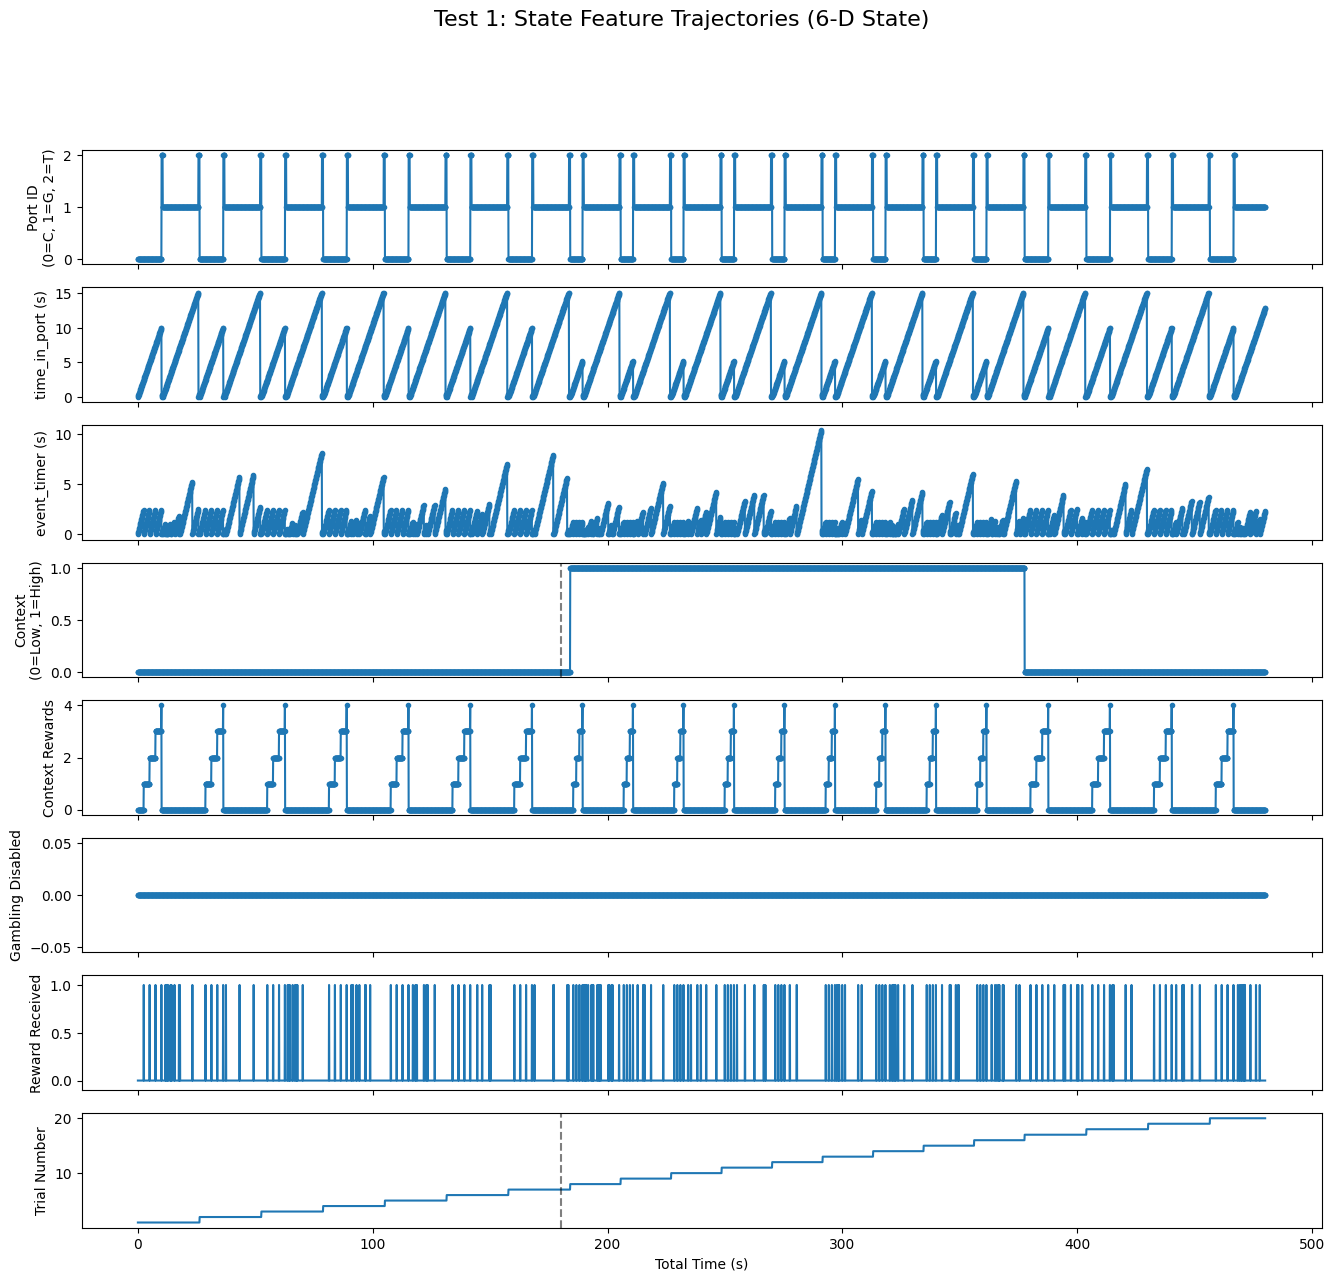

In [4]:
print("\n--- Running Test 1: Single Trajectory Smoke Test ---")
observation = env.env_start()
states = [observation]
total_reward = 0
is_terminal = False

rewards_received = [0]
trial_numbers = [1]
# simple dummy policy: stay for 15 sec in any port then leave
LEAVE_TIME = 15

while not is_terminal:
    port_id, time_in_port, event_timer, context, rewards, disabled = observation
    action = 0 # Default to stay

    if port_id == 2 and time_in_port >= env.travel_time:
        action = 1
    elif port_id == env.CONTEXT_PORT and rewards == env.context_rewards_max:
        action = 1 # Leave after finishing context
    elif port_id == env.GAMBLING_PORT and time_in_port >= LEAVE_TIME:
        action = 1 # Leave gambling after 15s

    reward, observation, is_terminal = env.env_step(action)
    states.append(observation)
    rewards_received.append(reward)
    trial_numbers.append(env.env_message("get_trial_number"))

states = np.array(states)
rewards_received = np.array(rewards_received)
trial_numbers = np.array(trial_numbers)

# Plot the state features over time
fig, axes = plt.subplots(8, 1, figsize=(16, 14), sharex=True)
time_points = np.arange(states.shape[0]) * env.dt

axes[0].plot(time_points, states[:, 0], '.-')
axes[0].set_ylabel("Port ID\n(0=C, 1=G, 2=T)")
axes[1].plot(time_points, states[:, 1], '.-')
axes[1].set_ylabel("time_in_port (s)")
axes[2].plot(time_points, states[:, 2], '.-')
axes[2].set_ylabel("event_timer (s)")
axes[3].plot(time_points, states[:, 3], '.-')
axes[3].set_ylabel("Context\n(0=Low, 1=High)")
axes[4].plot(time_points, states[:, 4], '.-')
axes[4].set_ylabel("Context Rewards")
axes[5].plot(time_points, states[:, 5], '.-')
axes[5].set_ylabel("Gambling Disabled")
axes[6].plot(time_points, rewards_received, '-')
axes[6].set_ylabel("Reward Received")
axes[6].set_ylim([-0.1, 1.1])
axes[7].plot(time_points, trial_numbers, '-')
axes[7].set_ylabel("Trial Number")
axes[7].set_xlabel("Total Time (s)")
axes[3].axvline(x=env.block_duration, color='k', linestyle='--', alpha=0.5)
axes[7].axvline(x=env.block_duration, color='k', linestyle='--', alpha=0.5)
fig.suptitle("Test 1: State Feature Trajectories (6-D State)", fontsize=16)
plt.show()

## Test 2: Context Port Validation

### 2a: Staying in the context port delivers exactly 4 rewards at the correct times and then stops

In [5]:
print("\n--- Running Test 2: Context Port Validation ---")
observation = env.env_start()
is_terminal = False
reward_times = []

while not is_terminal and observation[0] == env.CONTEXT_PORT:
    reward, observation, is_terminal = env.env_step(0) # Always stay
    if reward > 0:
        reward_times.append(observation[1])

final_context = observation[3]
print(f"Context: {'High' if final_context == 1 else 'Low'}")
print(f"Received {len(reward_times)} rewards in the Context Port.")
print(f"Reward times (s): {[round(t, 2) for t in reward_times]}")

# Rigorous check
assert len(reward_times) == 4, "TEST FAILED: Did not receive 4 rewards!"
interval = env.high_rate_interval if final_context == 1 else env.low_rate_interval
time_per_reward = np.ceil(interval / env.dt) * env.dt
expected_times = [(i + 1) * time_per_reward for i in range(4)]
print(f"Expected times (s): {[round(t, 2) for t in expected_times]}")
assert np.allclose(reward_times, expected_times, atol=env.dt), "TEST FAILED: Reward timing is incorrect!"

print("--- Test 2 Passed! ---")


--- Running Test 2: Context Port Validation ---
Context: High
Received 4 rewards in the Context Port.
Reward times (s): [np.float64(1.3), np.float64(2.6), np.float64(3.9), np.float64(5.2)]
Expected times (s): [np.float64(1.3), np.float64(2.6), np.float64(3.9), np.float64(5.2)]
--- Test 2 Passed! ---


### 2b: Validate the "resume" logic for the context port

In [6]:
print("\n--- Running Test 2b: Premature Leave & Resume Logic ---")
env.env_init(env_info) # Re-initialize
observation = env.env_start()
is_terminal = False
reward_times = []
time_of_leave = -1
time_of_return = -1

# Dummy policy: Wait for 1st reward, wait 1s more, then leave.
while not is_terminal:
    port_id, time_in_port, event_timer, _, rewards, disabled = observation
    action = 0 # Default to stay

    # If in context port...
    if port_id == env.CONTEXT_PORT:
        # After getting 1st reward and waiting 1 more second, leave.
        if rewards == 1 and time_of_leave < 0 and event_timer >= 1.0:
            action = 1
            time_of_leave = env.total_time_elapsed
            print(f"Leaving context port at {time_of_leave:.2f}s with {rewards} reward.")
        # If we have left and come back, just stay until the session ends
        elif rewards >= 2:
            break

    # If in gambling port (after leaving context), leave immediately to go back
    elif port_id == env.GAMBLING_PORT:
        action = 1

    elif port_id == 2:
        if time_in_port >= env.travel_time:
            action = 1

    # If traveling back to context port
    if is_terminal: break
    reward, observation, is_terminal = env.env_step(action)
    if reward > 0:
        reward_times.append(env.total_time_elapsed)

    if time_of_leave > 0 and time_of_return < 0 and observation[0] == env.CONTEXT_PORT:
        time_of_return = env.total_time_elapsed
        print(f"Returned to context port at {time_of_return:.2f}s.")

print(f"\nReward times: {[round(t, 2) for t in reward_times]}")
first_reward_time = reward_times[0]
second_reward_time = reward_times[1]
wait_time_after_return = second_reward_time - time_of_return

interval = env.low_rate_interval if observation[3] == 0 else env.high_rate_interval
expected_wait_time = interval - 1.0 # 2.5 (or 1.25) interval minus the 1.0s we waited before leaving

print(f"Waited {wait_time_after_return:.2f}s for 2nd reward after returning.")
print(f"Expected wait time was {expected_wait_time:.2f}s.")

assert np.isclose(wait_time_after_return, expected_wait_time, atol=env.dt), "TEST FAILED: Resume logic is incorrect!"
print("--- Test 2b Passed! ---")


--- Running Test 2b: Premature Leave & Resume Logic ---
Leaving context port at 3.60s with 1.0 reward.
Returned to context port at 4.80s.

Reward times: [2.5, 6.2]
Waited 1.40s for 2nd reward after returning.
Expected wait time was 1.50s.
--- Test 2b Passed! ---


## Test 3: Gambling Port Validation


--- Running Test 3: Statistical Validation of Gambling Port ---
Running 2000 trials, waiting 10.0s each time.
Theoretical average rewards per trial: 5.7437


100%|██████████| 2000/2000 [00:01<00:00, 1833.10it/s]


Empirical average rewards per trial:   5.7125

--- Test 3 Passed! ---


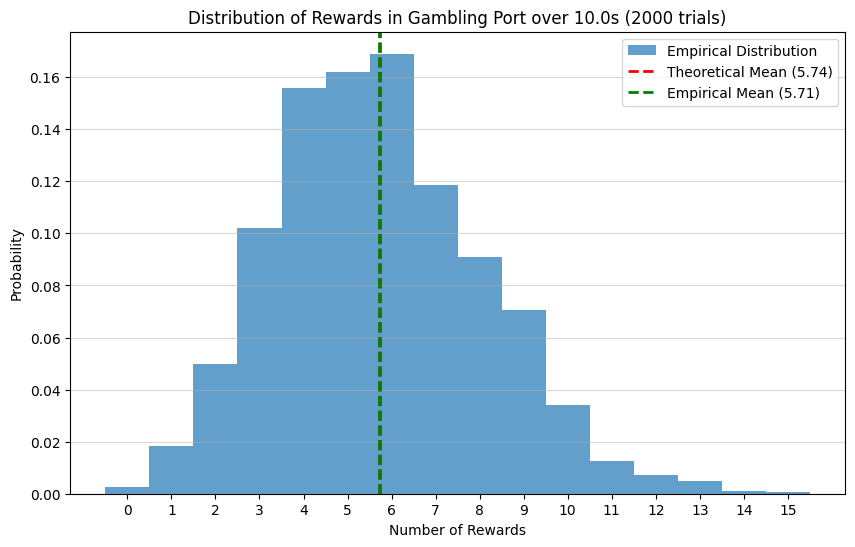

In [7]:
print("\n--- Running Test 3: Statistical Validation of Gambling Port ---")
from tqdm import tqdm
# --- 1. Helper function for the theoretical calculation ---
def calculate_theoretical_rewards(env, wait_duration):
    """Calculates the expected number of rewards for a fixed wait time."""
    expected_rewards = 0
    for t_step in range(int(wait_duration / env.dt)):
        time_in_port = t_step * env.dt
        # We call the environment's own probability function to ensure consistency
        prob = env._get_gambling_reward_prob(time_in_port)
        expected_rewards += prob
    return expected_rewards

# --- 2. Setup and run the simulation trials ---
env = ForagingEnvironment()
env_info = {"time_step_duration": 0.1, "seed": 2077}
env.env_init(env_info)

num_trials = 2000
wait_duration = 10.0  # How long the agent will wait in the gambling port per trial
rewards_per_trial = []

# Calculate the theoretical expectation first
theoretical_avg = calculate_theoretical_rewards(env, wait_duration)
print(f"Running {num_trials} trials, waiting {wait_duration}s each time.")
print(f"Theoretical average rewards per trial: {theoretical_avg:.4f}")

for _ in tqdm(range(num_trials)):
    observation = env.env_start()
    is_terminal = False

    # Dummy Agent Logic:
    # 1. Complete the context port task to unlock the gambling port.
    # 2. Go to the gambling port and wait for `wait_duration`.

    in_gambling_port = False
    rewards_this_trial = 0

    while not is_terminal:
        port_id, time_in_port, _, _, rewards_collected, _ = observation
        action = 0 # Stay by default

        if port_id == env.CONTEXT_PORT and rewards_collected == env.context_rewards_max:
            action = 1 # Leave context
        elif port_id == env.GAMBLING_PORT:
            in_gambling_port = True
            if time_in_port >= wait_duration:
                break # End this trial
        elif (port_id == 2) and (time_in_port >= env.travel_time):
            action = 1

        reward, observation, is_terminal = env.env_step(action)

        # Only count rewards once we are in the gambling port for this test
        if in_gambling_port and reward > 0:
            rewards_this_trial += 1

    rewards_per_trial.append(rewards_this_trial)

# --- 3. Compare empirical results to theoretical expectation ---
empirical_avg = np.mean(rewards_per_trial)
print(f"Empirical average rewards per trial:   {empirical_avg:.4f}")

# --- 4. Rigorous Check ---
# We expect the empirical average to be close to the theoretical one.
# A tolerance of 5% of the theoretical value is reasonable for this many trials.
assert np.isclose(theoretical_avg, empirical_avg, rtol=0.05), "TEST FAILED: Empirical average is too far from theoretical average!"
print("\n--- Test 3 Passed! ---")

# --- 5. Visualize the distribution ---
plt.figure(figsize=(10, 6))
plt.hist(rewards_per_trial, bins=np.arange(max(rewards_per_trial) + 2) - 0.5, density=True, alpha=0.7, label='Empirical Distribution')
plt.axvline(theoretical_avg, color='r', linestyle='--', linewidth=2, label=f'Theoretical Mean ({theoretical_avg:.2f})')
plt.axvline(empirical_avg, color='g', linestyle='--', linewidth=2, label=f'Empirical Mean ({empirical_avg:.2f})')
plt.title(f'Distribution of Rewards in Gambling Port over {wait_duration}s ({num_trials} trials)')
plt.xlabel("Number of Rewards")
plt.ylabel("Probability")
plt.xticks(np.arange(max(rewards_per_trial) + 1))
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

## Test 4: Block Switching Validation


--- Running Test 4: Trial-Aligned Block Switching Validation ---
Test starting in context: Low


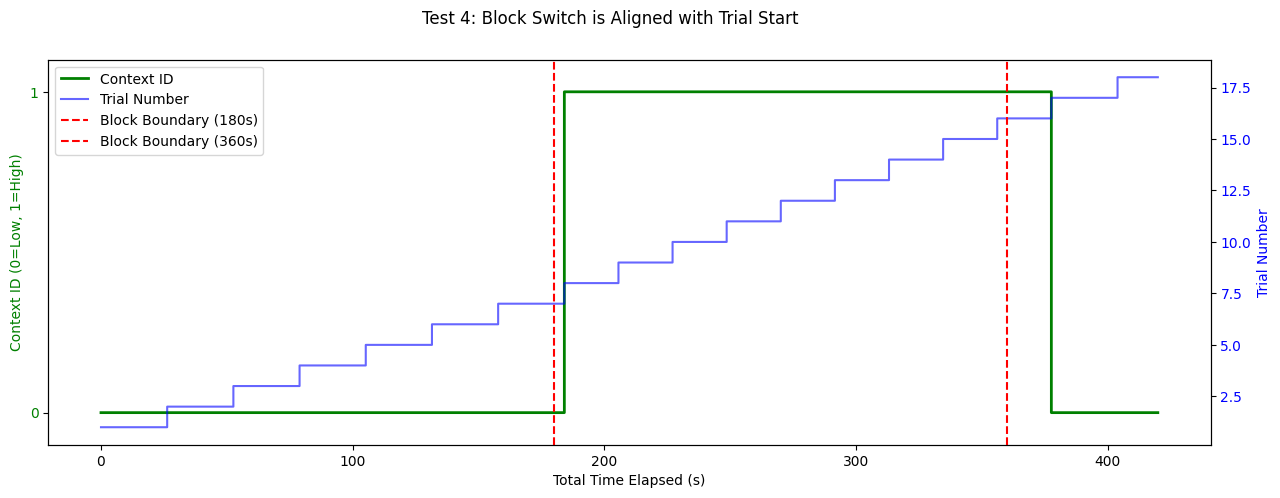

In [8]:
print("\n--- Running Test 4: Trial-Aligned Block Switching Validation ---")

env = ForagingEnvironment()
# Set a session duration long enough to see at least one block switch
env_info = {"time_step_duration": 0.1, "session_duration_min": 7, "seed": 2025}
env.env_init(env_info)

observation = env.env_start()
is_terminal = False

# Store a history of these variables for plotting
history = []
print(f"Test starting in context: {'High' if observation[3] == 1 else 'Low'}")

# This dummy agent completes full trials
while not is_terminal:
    port_id, time_in_port, _, _, rewards_collected, _ = observation
    action = 0 # Default action

    if port_id == 2: # If traveling, enter when time is up
        if time_in_port >= env.travel_time: action = 1
    elif port_id == env.CONTEXT_PORT:
        if rewards_collected == env.context_rewards_max: action = 1 # Leave when finished
    elif port_id == env.GAMBLING_PORT:
        if time_in_port >= 15.0: action = 1 # Leave after 15s

    # Record state *before* the step to align with the time axis
    history.append({
        "time": env.total_time_elapsed,
        "trial": env.env_message("get_trial_number"),
        "context": observation[3]
    })

    _, observation, is_terminal = env.env_step(action)

# --- Plotting ---
time_ax = np.array([h['time'] for h in history])
trial_ax = np.array([h['trial'] for h in history])
context_ax = np.array([h['context'] for h in history])

fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot context on the left y-axis
ax1.plot(time_ax, context_ax, 'g-', drawstyle='steps-post', label='Context ID', linewidth=2)
ax1.set_xlabel('Total Time Elapsed (s)')
ax1.set_ylabel('Context ID (0=Low, 1=High)', color='g')
ax1.set_yticks([0, 1])
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_ylim([-0.1, 1.1])

# Create a second y-axis for the trial number
ax2 = ax1.twinx()
ax2.plot(time_ax, trial_ax, 'b-', drawstyle='steps-post', alpha=0.6, label='Trial Number')
ax2.set_ylabel('Trial Number', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Mark the block boundary
plt.axvline(x=env.block_duration, color='r', linestyle='--', label=f'Block Boundary ({env.block_duration}s)')
plt.axvline(x=env.block_duration * 2, color='r', linestyle='--', label=f'Block Boundary ({env.block_duration * 2}s)')

fig.suptitle("Test 4: Block Switch is Aligned with Trial Start")
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()


# Test the convert_behavior_data_to_state_transitions function

In [1]:
import data_loader

In [2]:
pi_events = data_loader.load_behavior_data("SZ036", session_id=5)

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-02T20_06_pi_events_processed.parquet
session: SZ036_2024-01-02T20_06


In [3]:
env_params = {
    "time_step_duration": 0.1,
    "travel_time": 0.4,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}
transitions = data_loader.convert_behavior_data_to_state_transitions(pi_events, env_params)


Processing time steps...
Processed 10800 time steps.


In [4]:
trace_port = [transition[0][0] for transition in transitions][1:]
trace_NRI = [transition[0][1] for transition in transitions][1:]
trace_IRI = [transition[0][2] for transition in transitions][1:]
trace_context = [transition[0][3] for transition in transitions][1:]
trace_context_rewards = [transition[0][4] for transition in transitions][1:]
trace_gambling_disabled = [transition[0][5] for transition in transitions][1:]
trace_action = [transition[1] for transition in transitions][1:]
trace_reward_next_state = [transition[2] for transition in transitions][1:]

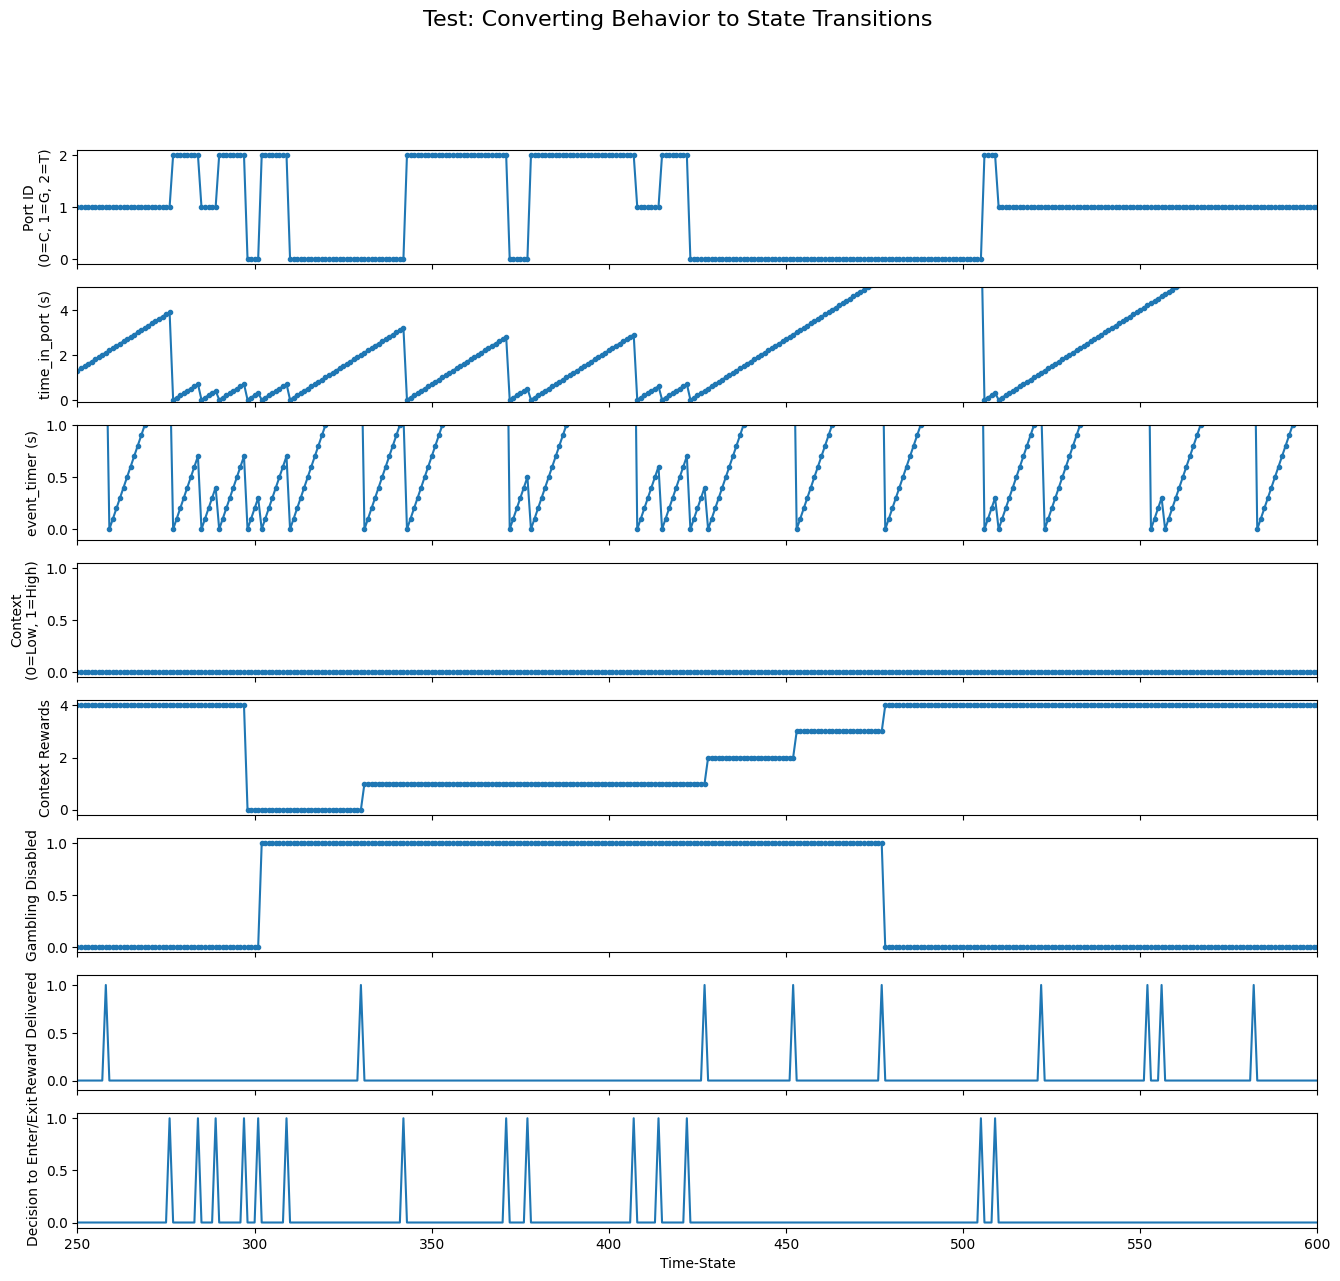

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(8, 1, figsize=(16, 14), sharex=True)

axes[0].plot(trace_port, '.-')
axes[0].set_ylabel("Port ID\n(0=C, 1=G, 2=T)")
axes[1].plot(trace_NRI, '.-')
axes[1].set_ylabel("time_in_port (s)")
axes[1].set_ylim([-0.1, 5])
axes[2].plot(trace_IRI, '.-')
axes[2].set_ylabel("event_timer (s)")
axes[2].set_ylim([-0.1, 1])
axes[3].plot(trace_context, '.-')
axes[3].set_ylabel("Context\n(0=Low, 1=High)")
axes[4].plot(trace_context_rewards, '.-')
axes[4].set_ylabel("Context Rewards")
axes[5].plot(trace_gambling_disabled, '.-')
axes[5].set_ylabel("Gambling Disabled")
axes[6].plot(trace_reward_next_state, '-')
axes[6].set_ylabel("Reward Delivered")
axes[6].set_ylim([-0.1, 1.1])
axes[7].plot(trace_action, '-')
axes[7].set_ylabel("Decision to Enter/Exit")
axes[7].set_xlabel("Time-State")
for ax in axes:
    ax.set_xlim([250, 600])
fig.suptitle("Test: Converting Behavior to State Transitions", fontsize=16)
plt.show()

# Test run the simulation for behavior data from one expert session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mouse_playback_environment import MousePlaybackEnvironment
from mouse_playback_agent import MousePlaybackAgent
from data_loader import load_behavior_data, convert_behavior_data_to_state_transitions
from tqdm import tqdm

In [10]:
# --- Load and Convert Data ---
env_params_for_conversion = { # Params needed by the data loader
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}
pi_events_df = load_behavior_data("SZ036", session_id=7) # Example
if pi_events_df is None:
    raise FileNotFoundError("Could not load behavior data.")

transitions = convert_behavior_data_to_state_transitions(pi_events_df, env_params_for_conversion)
if not transitions:
     raise ValueError("Data conversion resulted in empty transitions list.")

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-04T11_40_pi_events_processed.parquet
session: SZ036_2024-01-04T11_40
Processing time steps...
Processed 10800 time steps.


In [23]:
# Simulation Setup
env_info_playback = { # Info needed by the playback environment
    'transitions': transitions,
    'time_step_duration': env_params_for_conversion['time_step_duration']
}
agent_info = {
    "discount": 0.95,
    "step_size": 0.1,
    "num_tilings": 50,
    "tiles_per_dim": [4, 30, 10, 2, 5, 2],
    "iht_size": 4096,
    # Pass necessary scaling info if agent needs it
    "gambling_max_time_s": 30.0, # Example, adjust if needed
    "context_rewards_max": 4   # Example, adjust if needed
}

env = MousePlaybackEnvironment()
agent = MousePlaybackAgent()

env.env_init(env_info_playback)
agent.agent_init(agent_info)

Playback environment initialized with 10800 transitions.


In [24]:
# Run the playback simulation
all_trial_values = []
current_trial_data = []
was_in_gambling = False

GAMBLING_PORT_ID = 1.0
GAMBLING_ENABLED = 0.0
NUM_TRIALS_TO_PLOT = 50

observation = env.env_start()
agent.agent_start(observation)
terminal = False
step_count = 0
max_steps = len(transitions)

print("Running playback simulation using MousePlaybackEnvironment...")
while not terminal and step_count < max_steps:
    port_id, time_in_port, _, _, _, gambling_disabled = observation
    is_in_gambling = (port_id == GAMBLING_PORT_ID and gambling_disabled == GAMBLING_ENABLED)
    # Check if we just entered the gambling port
    if is_in_gambling and not was_in_gambling:
        current_trial_data = [] # Start a new trial trace

    # If we are in the port, record the time and value
    if is_in_gambling:
        # Get V(s_t) using the agent's weights *at time t*
        current_value = agent.get_value(observation)
        current_trial_data.append((time_in_port, current_value))

    # Check if we just *left* the gambling port
    if not is_in_gambling and was_in_gambling:
        if current_trial_data: # If we have data, save it
            all_trial_values.append(list(current_trial_data))
        if len(all_trial_values) >= NUM_TRIALS_TO_PLOT:
            print(f"Captured {len(all_trial_values)} trials. Stopping capture.")
            break # Stop the whole simulation

    was_in_gambling = is_in_gambling # Update state flag for next loop

    dummy_action = 0
    reward, next_observation, terminal = env.env_step(dummy_action)

    # Agent learns based on the outcome provided by the environment
    if terminal:
        agent.agent_end(reward)
    else:
        agent.agent_step(reward, next_observation)

    observation = next_observation # For the next loop iteration (though not used by agent.agent_step)
    step_count += 1

# Get results
if current_trial_data and len(all_trial_values) < NUM_TRIALS_TO_PLOT:
    all_trial_values.append(list(current_trial_data))
print(f"Playback finished. Captured {len(all_trial_values)} trials.")

td_errors = np.array(agent.agent_message("get_td_errors"))
all_observations = np.array([t[0] for t in transitions]) # Retrieve observations from the transitions list
print(f"Playback finished after {step_count} steps.")

Running playback simulation using MousePlaybackEnvironment...
Captured 50 trials. Stopping capture.
Playback finished. Captured 50 trials.
Playback finished after 10186 steps.


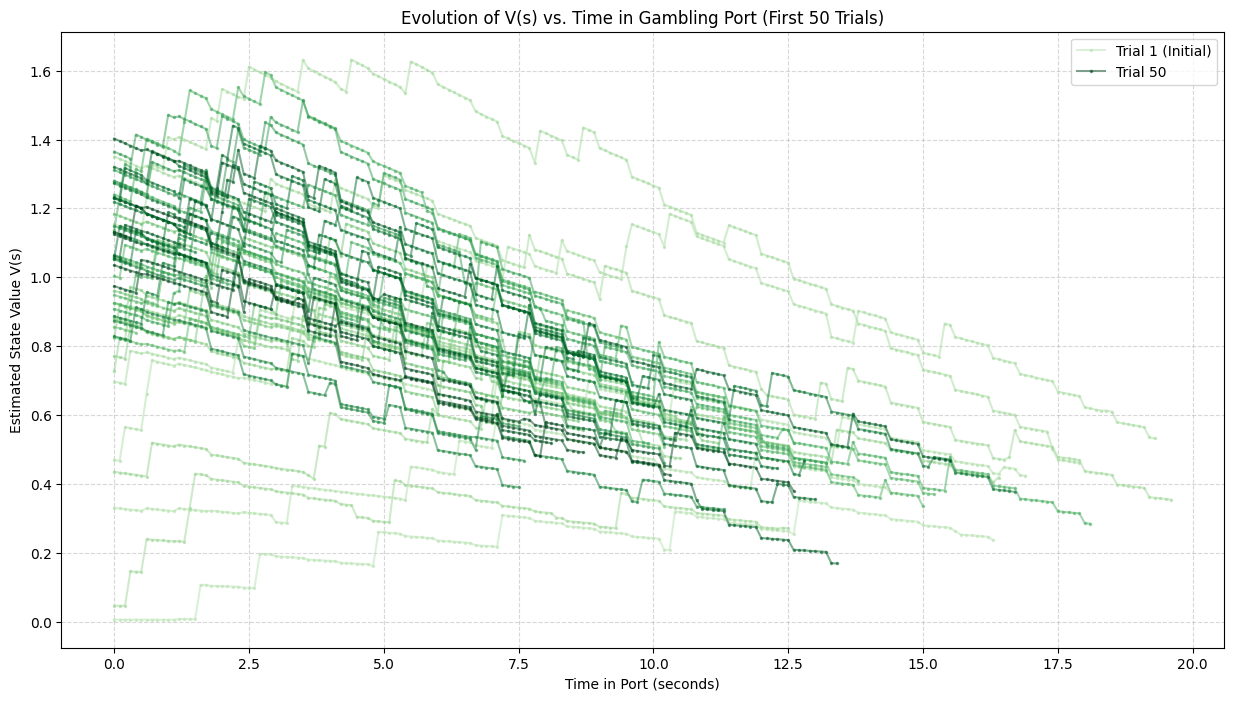

In [25]:
# Plot V(s) Evolution
plt.figure(figsize=(15, 8))

num_trials = len(all_trial_values)
if num_trials > 0:
    # Generate colors from light green (0.3) to dark green (1.0)
    colors = cm.Greens(np.linspace(0.3, 1, num_trials))

    for i, trial_data in enumerate(all_trial_values):
        # trial_data is a list of (time_in_port, value) tuples
        if not trial_data: # Skip empty trials
            continue

        times, values = zip(*trial_data)

        # Set label only for first and last trial for a cleaner legend
        label = None
        if i == 0:
            label = f'Trial 1 (Initial)'
        elif i == num_trials - 1:
            label = f'Trial {num_trials}'

        plt.plot(times, values, '.-', color=colors[i], alpha=0.5, markersize=3, label=label)

    plt.title(f'Evolution of V(s) vs. Time in Gambling Port (First {num_trials} Trials)')
    plt.xlabel('Time in Port (seconds)')
    plt.ylabel('Estimated State Value V(s)')

    # Check if any data was actually plotted before adding legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend(handles, labels)
    else:
        print("No data was plotted (all captured trials might be empty).")

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

else:
    print("No gambling trials were captured, cannot generate plot.")

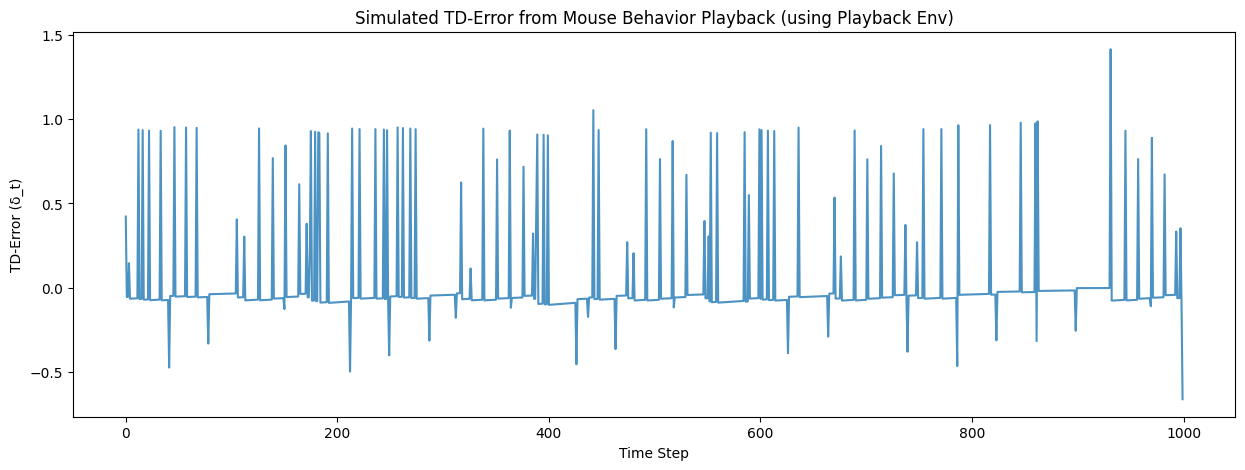

In [11]:
# Plot TD-error results
plt.figure(figsize=(15, 5))
plt.plot(td_errors[-1000:], alpha=0.8)
plt.title("Simulated TD-Error from Mouse Behavior Playback (using Playback Env)")
plt.xlabel("Time Step")
plt.ylabel("TD-Error (δ_t)")
plt.show()

In [13]:
# test
all_rewards = np.array([t[2] for t in transitions])

# --- Find indices where a reward was delivered ---
reward_indices = np.where(all_rewards == 1.0)[0]

# --- Verification Step: Check a few instances ---
print("\n--- Verification: Checking TD-Error for steps after rewards ---")
gambling_port_id = 1
verified_indices_found = [] # Keep track of indices we expect in the plot
check_count = 0
max_checks = 5 # How many instances to print

for reward_idx in reward_indices:
    if reward_idx + 1 < len(td_errors):

        # State entered *after* the reward (this is obs_t_plus_1 from the reward transition)
        state_after_reward = transitions[reward_idx][3] # equivalent to all_observations[reward_idx + 1]

        # Check if this state is in the gambling port
        if state_after_reward[0] == gambling_port_id:

            # The TD-error calculated *during* the step STARTING from state_after_reward
            td_error_after_reward = td_errors[reward_idx]
            time_in_port_at_error_calc = state_after_reward[1] # Time in port when error was calculated

            # Print details for verification
            if check_count < max_checks:
                print(f"\nInstance {check_count + 1}:")
                print(f"  Reward occurred at step index: {reward_idx}")
                print(f"  State entered after reward (obs_t for next step): {np.round(state_after_reward, 2)}")
                print(f"  TD-Error calculated at NEXT step (index {reward_idx + 1}): {td_error_after_reward:.4f}")
                print(f"  Time in Port at TD-Error calculation: {time_in_port_at_error_calc:.2f}s")

            verified_indices_found.append(reward_idx + 1) # Store the index of the TD-error step
            check_count += 1

# --- Compare verified indices with the ones selected for plotting ---
print(f"\nTotal reward indices found: {len(reward_indices)}")
print(f"Total indices meeting criteria (in gambling port, step after reward): {len(verified_indices_found)}")


--- Verification: Checking TD-Error for steps after rewards ---

Instance 1:
  Reward occurred at step index: 259
  State entered after reward (obs_t for next step): [1.  2.2 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 260): 1.0000
  Time in Port at TD-Error calculation: 2.20s

Instance 2:
  Reward occurred at step index: 523
  State entered after reward (obs_t for next step): [1.  1.3 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 524): 0.9960
  Time in Port at TD-Error calculation: 1.30s

Instance 3:
  Reward occurred at step index: 553
  State entered after reward (obs_t for next step): [1.  4.3 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 554): 0.9934
  Time in Port at TD-Error calculation: 4.30s

Instance 4:
  Reward occurred at step index: 557
  State entered after reward (obs_t for next step): [1.  4.7 0.  0.  4.  0. ]
  TD-Error calculated at NEXT step (index 558): 0.9886
  Time in Port at TD-Error calculation: 4.70s

Instance 5:
  Rewa

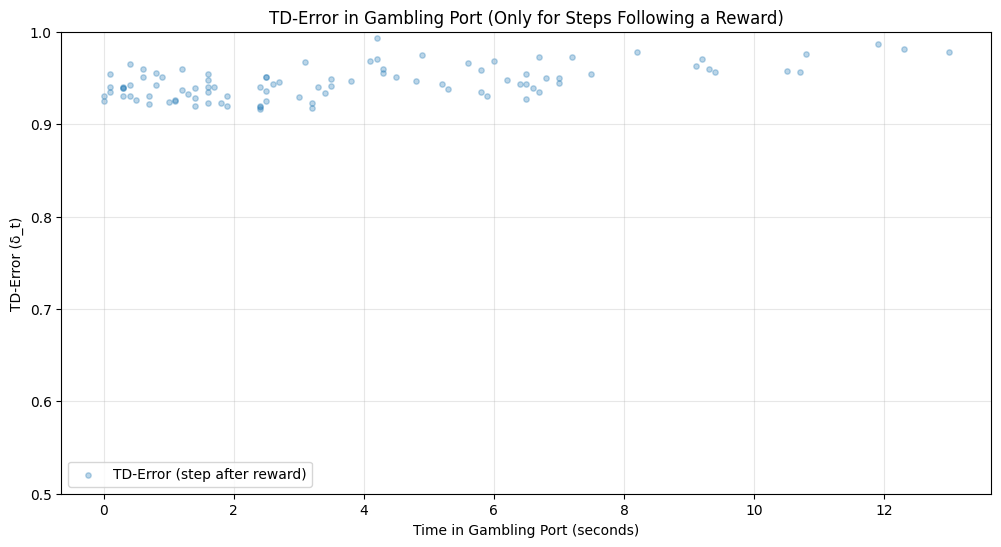

In [20]:
# plot td-error vs. time_in_port in the gambling port
all_rewards = np.array([t[2] for t in transitions])

indices_to_plot = []
gambling_port_id = 1

# Start loop from 1 (so we can check i-1)
for i in range(1, len(transitions)):

    # Condition 1: A reward was delivered in the previous step (i-1)
    reward_in_prev_step = (all_rewards[i] == 1.0)

    # Condition 2: The current state (i) is in the gambling port
    in_gambling_port = (all_observations[i, 0] == gambling_port_id)

    if reward_in_prev_step and in_gambling_port:
        indices_to_plot.append(i)

# Filter data using the selected indices
if indices_to_plot:
    td_errors_filtered = td_errors[indices_to_plot]
    observations_filtered = all_observations[indices_to_plot]

    # Extract the 'time_in_port' (index 1) from the filtered observations
    time_in_port_filtered = observations_filtered[:, 1]

    # --- Create the Scatter Plot ---
    plt.figure(figsize=(12, 6))
    plt.scatter(time_in_port_filtered[100:200], td_errors_filtered[100:200], alpha=0.3, s=15,
                label="TD-Error (step after reward)")

    plt.ylim([0.5, 1])
    plt.title("TD-Error in Gambling Port (Only for Steps Following a Reward)")
    plt.xlabel("Time in Gambling Port (seconds)")
    plt.ylabel("TD-Error (δ_t)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("No data points matched the criteria (in gambling port and step after a reward).")

# Pre-train agent with pooled data from representational sessions and analyze TD-error for target sessions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mouse_playback_environment import MousePlaybackEnvironment # NEW
from mouse_playback_agent import MousePlaybackAgent
from data_loader import load_behavior_data, load_pretraining_data, convert_behavior_data_to_state_transitions

## 1. Pretraining

In [2]:
import pandas as pd
import os
import config
import glob

def pool_animal_transitions(animal_str, env_params):
    """
    Finds all processed .parquet files for an animal, loads them,
    converts them to transitions, and pools them together.
    """
    print(f"--- Pooling data for animal: {animal_str} ---")
    pooled_transitions = []

    # 1. Find the directory with the processed files
    animal_dir = os.path.normpath(os.path.join(config.MAIN_DATA_ROOT, animal_str))
    processed_dir = os.path.join(animal_dir, config.PRETRAINING_PROCESSED_DATA_SUBDIR)

    # 2. Create a "pattern" to find all .parquet files
    file_pattern = os.path.join(processed_dir, "*_pi_events_proccessed.parquet")

    # 3. Use glob to get a list of all files matching the pattern
    session_files = glob.glob(file_pattern)

    if not session_files:
        print(f"⚠️ No .parquet files found for {animal_str} in {processed_dir}")
        return []

    print(f"Found {len(session_files)} sessions to pool.")

    # 4. Loop through the list of files
    for file_path in session_files:
        try:
            df = pd.read_parquet(file_path)

            if df.empty:
                print(f"Skipping empty session file: {os.path.basename(file_path)}")
                continue

            session_transitions = convert_behavior_data_to_state_transitions(df, env_params)

            pooled_transitions.extend(session_transitions)

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"⚠️ ERROR: Failed to process file: {os.path.basename(file_path)}")
            print(f"   Error details: {e}")
            print(f"   Skipping this file.")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            continue

    print(f"--- Finished pooling for {animal_str} ---")
    print(f"Total transitions pooled: {len(pooled_transitions)}")

    return pooled_transitions

In [3]:
# Pool the data first
env_params = { # Params needed by the data loader
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
}

animal_to_pool = "SZ037"
pooled_transitions = pool_animal_transitions(animal_to_pool, env_params)

--- Pooling data for animal: SZ037 ---
Found 65 sessions to pool.
Processing time steps...
Processed 10732 time steps.
Processing time steps...
Processed 10746 time steps.
Processing time steps...
Processed 10780 time steps.
Processing time steps...
Processed 10790 time steps.
Processing time steps...
Processed 10796 time steps.
Processing time steps...
Processed 10796 time steps.
Processing time steps...
Processed 10788 time steps.
Processing time steps...
Processed 10794 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10788 time steps.
Processing time steps...
Processed 10781 time steps.
Processing time steps...
Processed 10797 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10798 time steps.
Processing time steps...
Processed 10758 time steps.
Processing time steps...
Processed 10789 time steps.
Processing time steps...
Processed 10749 time steps.
Processing time steps...
Processe

In [4]:
# Save pooled transitions
import pickle

filename = f'pooled_transitions_{animal_to_pool}.pkl'

print(f"Saving list to {filename}...")
try:
    # 'wb' mode means 'write binary'
    with open(filename, 'wb') as file:
        # pickle.dump() serializes the object and writes to the file
        pickle.dump(pooled_transitions, file)
    print("List saved successfully.")

except IOError as e:
    print(f"Error saving file: {e}")
except pickle.PicklingError as e:
    print(f"Error pickling object: {e}")

Saving list to pooled_transitions_SZ037.pkl...
List saved successfully.


In [5]:
# Set up the environment and the agent
env = MousePlaybackEnvironment()
agent = MousePlaybackAgent()

env_params_for_playback = {"transitions": pooled_transitions, "time_step_duration": 0.1} # Add other params if needed by env
agent_params = {
    "discount": 0.95, # Or chosen value
    "step_size": 0.2, # Start with a smaller step size for stability over large datasets
    "num_tilings": 8,
    "tiles_per_dim": [4, 10, 10, 2, 5, 2],
    "iht_size": 4096,
    "gambling_max_time_s": 30.0, # Match data_loader params if used
    "context_rewards_max": 4   # Match data_loader params if used
} # agent parameters

agent.agent_init(agent_params)
env.env_init(env_params_for_playback)

Playback environment initialized with 700965 transitions.


In [6]:
# Iterative training
import numpy as np
from tqdm import tqdm # for progress bar

max_epochs = 20 # Adjust as needed
convergence_threshold = 1e-6 # Adjust as needed
last_w = agent.w.copy()
weight_change_across_epochs = []

num_total_steps = len(pooled_transitions) # Total transitions in the pooled list

for epoch in range(max_epochs):
    print(f"Starting Epoch {epoch+1}/{max_epochs}")

    # --- Start the very first episode of the epoch ---
    current_observation = env.env_start() # Resets env index to 0
    agent.agent_start(current_observation)

    # for step_idx in tqdm(range(num_total_steps)):
    for step_idx in range(num_total_steps):
        # Action is ignored by the playback environment
        reward, next_observation, terminal = env.env_step(action=None)

        if terminal:
            agent.agent_end(reward)
            # Check if this is the end of the entire pooled list
            if env.current_step_index < num_total_steps:
                 # --- Start the next episode within the epoch ---
                 # The environment has already advanced its index, so next_observation
                 # is the start state of the next session in the pool.
                 current_observation = next_observation
                 agent.agent_start(current_observation)
            else:
                 # This was the very last transition in the pool
                 break # End the epoch
        else:
            # Standard step within an episode
            agent.agent_step(reward, next_observation)
            current_observation = next_observation # Update for the next iteration if not terminal

    # --- Check for convergence after each epoch ---
    w_change = np.sqrt(np.sum((agent.w - last_w)**2))
    weight_change_across_epochs.append(w_change)
    print(f"Epoch {epoch+1} finished. Weight change (L2 norm): {w_change:.8f}")
    if w_change < convergence_threshold and epoch > 0:
        print("Convergence detected.")
        break
    last_w = agent.w.copy()
    # Reset environment index for the next epoch pass (handled by env.env_start() at loop top)

# --- Save the converged weights ---
converged_weights = agent.w.copy()
np.save(f"expert_agent_weights_{animal_to_pool}.npy", converged_weights)
print("Saved converged expert weights.")

Starting Epoch 1/20
Epoch 1 finished. Weight change (L2 norm): 1.87152809
Starting Epoch 2/20
Epoch 2 finished. Weight change (L2 norm): 0.27566107
Starting Epoch 3/20
Epoch 3 finished. Weight change (L2 norm): 0.15011641
Starting Epoch 4/20
Epoch 4 finished. Weight change (L2 norm): 0.10836802
Starting Epoch 5/20
Epoch 5 finished. Weight change (L2 norm): 0.08523051
Starting Epoch 6/20
Epoch 6 finished. Weight change (L2 norm): 0.06939359
Starting Epoch 7/20
Epoch 7 finished. Weight change (L2 norm): 0.05782540
Starting Epoch 8/20
Epoch 8 finished. Weight change (L2 norm): 0.04910982
Starting Epoch 9/20
Epoch 9 finished. Weight change (L2 norm): 0.04239199
Starting Epoch 10/20
Epoch 10 finished. Weight change (L2 norm): 0.03710895
Starting Epoch 11/20
Epoch 11 finished. Weight change (L2 norm): 0.03287572
Starting Epoch 12/20
Epoch 12 finished. Weight change (L2 norm): 0.02942323
Starting Epoch 13/20
Epoch 13 finished. Weight change (L2 norm): 0.02656032
Starting Epoch 14/20
Epoch 14 

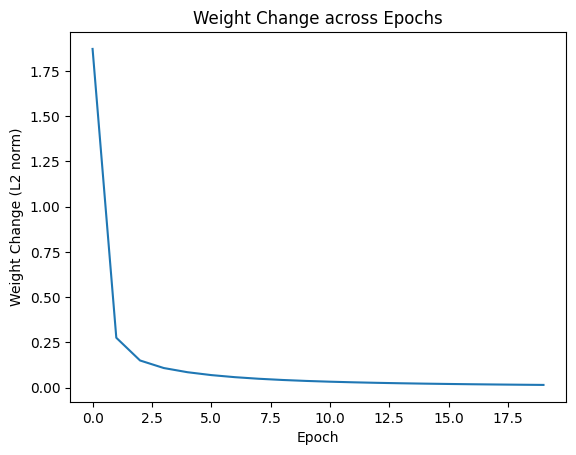

In [7]:
# plot weight changes
fig, ax = plt.subplots()
ax.plot(weight_change_across_epochs)
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight Change (L2 norm)")
ax.set_title("Weight Change across Epochs")
plt.show()

## 2. Analyze TD Errors and TD Values of Target Dataset

In [19]:
import numpy as np
expert_weights = np.load(f"expert_agent_weights_{animal_to_pool}.npy")

In [20]:
target_animal_id = animal_to_pool # Example
target_session_id = 5

target_df = load_behavior_data(target_animal_id, session_id=target_session_id)
if target_df is not None:
    env_params = {
    "time_step_duration": 0.1,
    "session_duration_min": 18,
    "context_rewards_max": 4,
    "block_duration_min": 3
    }
    target_transitions = convert_behavior_data_to_state_transitions(target_df, env_params)
    print(f"Loaded {len(target_transitions)} transitions for target session.")
else:
    raise ValueError("Failed to load target session data.")

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ037\processed_data\SZ037_2023-12-19T13_16_pi_events_processed.parquet
session: SZ037_2023-12-19T13_16
Processing time steps...
Processed 10799 time steps.
Loaded 10799 transitions for target session.


In [21]:
# Define agent parameters (should match pre-training parameters ideally)
agent_params = {
    "discount": 0.9,
    "step_size": 0.1, # IMPORTANT: Set step_size to 0 for analysis-only run if desired
                       # Alternatively, keep it small and just extract TD errors before update
    "num_tilings": 8,
    "tiles_per_dim": [4, 10, 10, 2, 5, 2],
    "iht_size": 4096,
    "gambling_max_time_s": 30.0,
    "context_rewards_max": 4
}

analysis_agent = MousePlaybackAgent()
analysis_agent.agent_init(agent_params)

# *** Set the weights as expert weights ***
if expert_weights.shape == analysis_agent.w.shape:
    analysis_agent.w = expert_weights.copy() # Use copy to avoid potential issues
    print("Agent weights initialized with pre-trained expert weights.")
else:
    raise ValueError(f"Loaded weights shape {expert_weights.shape} does not match agent weight shape {analysis_agent.w.shape}")

Agent weights initialized with pre-trained expert weights.


In [22]:
# Initialize environment
analysis_env = MousePlaybackEnvironment()
env_params_for_playback = {"transitions": target_transitions, "time_step_duration": 0.1}
analysis_env.env_init(env_params_for_playback)

Playback environment initialized with 10799 transitions.


### 2.1 TD values

In [23]:
# --- Define Constants ---
gambling_port_id = 1.0
gambling_enabled_flag = 0.0

# --- Extract Relevant States and Calculate Values ---
visited_gambling_states = {} # Use a dict to store unique states (key=tuple(obs), value=value)

print("Extracting unique gambling states and calculating values...")
for obs_t, _, _, _, _ in target_transitions:
    # Check conditions: in gambling port AND gambling enabled
    if obs_t[0] == gambling_port_id and obs_t[5] == gambling_enabled_flag:
        # Use a tuple representation of the state as a dictionary key for uniqueness
        state_tuple = tuple(np.round(obs_t, 3)) # Round to handle minor float variations
        if state_tuple not in visited_gambling_states:
             # Calculate value only for unique states encountered
            visited_gambling_states[state_tuple] = analysis_agent.get_value(np.array(state_tuple))

print(f"Found {len(visited_gambling_states)} unique relevant gambling states.")

Extracting unique gambling states and calculating values...
Found 4468 unique relevant gambling states.


In [24]:
# --- Prepare Data for Plotting (e.g., into a list of dictionaries or DataFrame) ---
# This structure makes it easy to filter/group later
plot_data = []
for state_tuple, value in visited_gambling_states.items():
    plot_data.append({
        'port': state_tuple[0],
        'time_in_port': state_tuple[1],
        'event_timer': state_tuple[2],
        'context': int(state_tuple[3]), # Convert context back to integer for easier grouping
        'rewards_in_context': state_tuple[4],
        'gambling_disabled': state_tuple[5],
        'value': value
    })

# Convert to pandas DataFrame for easier handling (optional but recommended)
plot_df = pd.DataFrame(plot_data)

In [25]:
# --- Define Plotting Function ---
def plot_gambling_value_vs_time_avg(data_df, split_by_context=False, title_suffix=""):
    """
    Plots the AVERAGE agent's estimated value V(s) vs. time_in_port
    for gambling states, with error bars (SEM).

    Args:
        data_df (pd.DataFrame): DataFrame containing state features and 'value'.
                                Must include 'time_in_port', 'context', and 'value' columns.
        split_by_context (bool): If True, plots data for each context separately.
        title_suffix (str): Optional suffix to add to the plot title.
    """
    plt.figure(figsize=(12, 7))

    if split_by_context:
        contexts = sorted(data_df['context'].unique())
        for context_val in contexts:
            context_data = data_df[data_df['context'] == context_val]
            # Group by time_in_port and calculate mean and standard error of the mean (SEM)
            avg_values = context_data.groupby('time_in_port')['value'].agg(['mean', 'sem']).reset_index()

            plt.errorbar(avg_values['time_in_port'], avg_values['mean'], yerr=avg_values['sem'],
                         label=f'Context {context_val}', fmt='-o', capsize=3, alpha=0.8) # Line plot with markers and error bars

        plt.title(f"Average Agent Value in Gambling Port vs. Time (Split by Context){title_suffix}")
        plt.legend()
    else:
        # Group by time_in_port and calculate mean and SEM
        avg_values = data_df.groupby('time_in_port')['value'].agg(['mean', 'sem']).reset_index()

        plt.errorbar(avg_values['time_in_port'], avg_values['mean'], yerr=avg_values['sem'],
                     label='All Contexts', fmt='-o', capsize=3, alpha=0.8) # Line plot with markers and error bars
        plt.title(f"Average Agent Value in Gambling Port vs. Time (All Contexts){title_suffix}")

    plt.xlabel("Time in Gambling Port (sec)")
    plt.ylabel("Average Estimated State Value V(s) +/- SEM")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

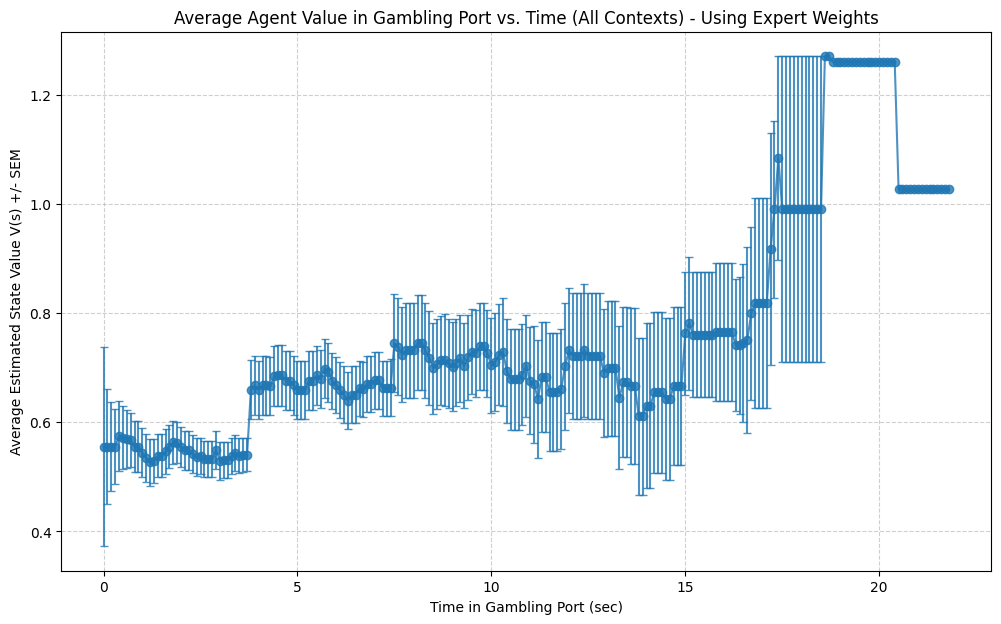

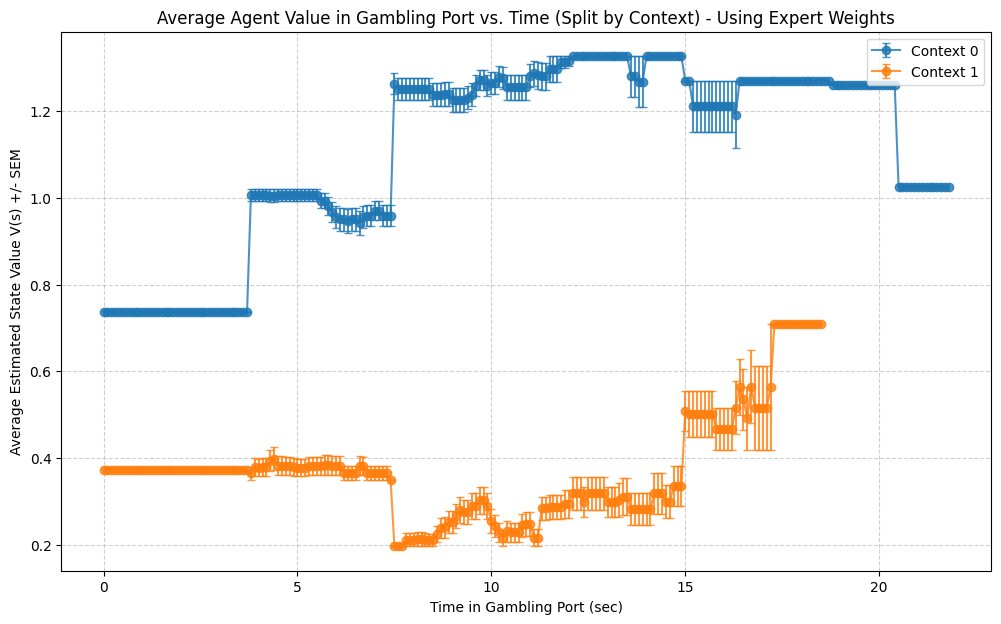

In [26]:
# plot
# Plot all contexts together
plot_gambling_value_vs_time_avg(plot_df, split_by_context=False, title_suffix=" - Using Expert Weights")

# Plot split by context
plot_gambling_value_vs_time_avg(plot_df, split_by_context=True, title_suffix=" - Using Expert Weights")

### 2.2 TD errors

In [27]:
target_td_errors = [] # List to store TD errors

current_observation = analysis_env.env_start()
analysis_agent.agent_start(current_observation)

num_target_steps = len(target_transitions)

for step_idx in range(num_target_steps):
    reward, next_observation, terminal = analysis_env.env_step(action=None) # Action is ignored

    # --- Calculate TD error ---
    v_next = analysis_agent.get_value(next_observation) if not terminal else 0.0
    v_current = analysis_agent.get_value(current_observation) # Value before potential update
    td_error = reward + analysis_agent.discount * v_next - v_current
    target_td_errors.append(td_error)
    # --------------------------------------------------------------------------

    if terminal:
        analysis_agent.agent_end(reward) # Agent updates internal state (even w/ alpha=0)
        break
    else:
        analysis_agent.agent_step(reward, next_observation) # Agent updates internal state (like last_state_tiles)
        current_observation = next_observation

print(f"Collected {len(target_td_errors)} TD errors for the target session.")

# Convert to NumPy array for easier analysis
target_td_errors_np = np.array(target_td_errors)

Collected 10799 TD errors for the target session.


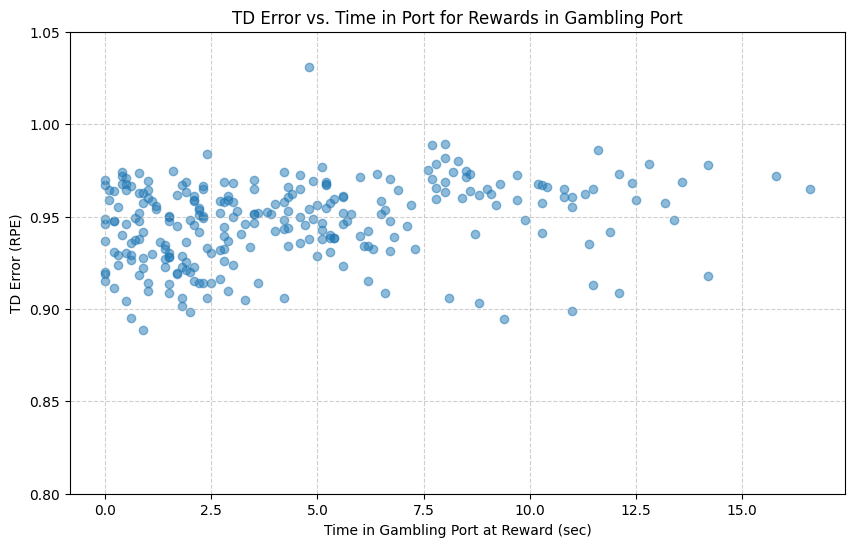

In [28]:
# Find the TD-errors corresponding to rewards delivere in the gambling port
import matplotlib.pyplot as plt

gambling_port_id = 1.0 # ID for the gambling port
rewarded_gambling_steps_time = []
rewarded_gambling_steps_td_error = []

# Iterate through the transitions and corresponding TD errors
for i in range(len(target_transitions)):
    obs_t, _, reward_t_plus_1, _, _ = target_transitions[i]
    td_error = target_td_errors_np[i]

    # Check if reward was given AND the port was the gambling port
    if reward_t_plus_1 > 0 and obs_t[0] == gambling_port_id:
        time_in_port = obs_t[1]
        rewarded_gambling_steps_time.append(time_in_port)
        rewarded_gambling_steps_td_error.append(td_error)

# --- Plotting ---
if not rewarded_gambling_steps_time:
    print("No rewarded steps found in the gambling port for this session.")
else:
    plt.figure(figsize=(10, 6))
    plt.scatter(rewarded_gambling_steps_time, rewarded_gambling_steps_td_error, alpha=0.5)
    plt.xlabel("Time in Gambling Port at Reward (sec)")
    plt.ylabel("TD Error (RPE)")
    plt.ylim([0.8, 1.05])
    plt.title("TD Error vs. Time in Port for Rewards in Gambling Port")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Find the reason why TD-values increase as time in gambling port increases

### (1) Values and Errors, Separated

Extracting TD error components for rewarded gambling steps...
Found 282 rewarded steps in enabled gambling port.


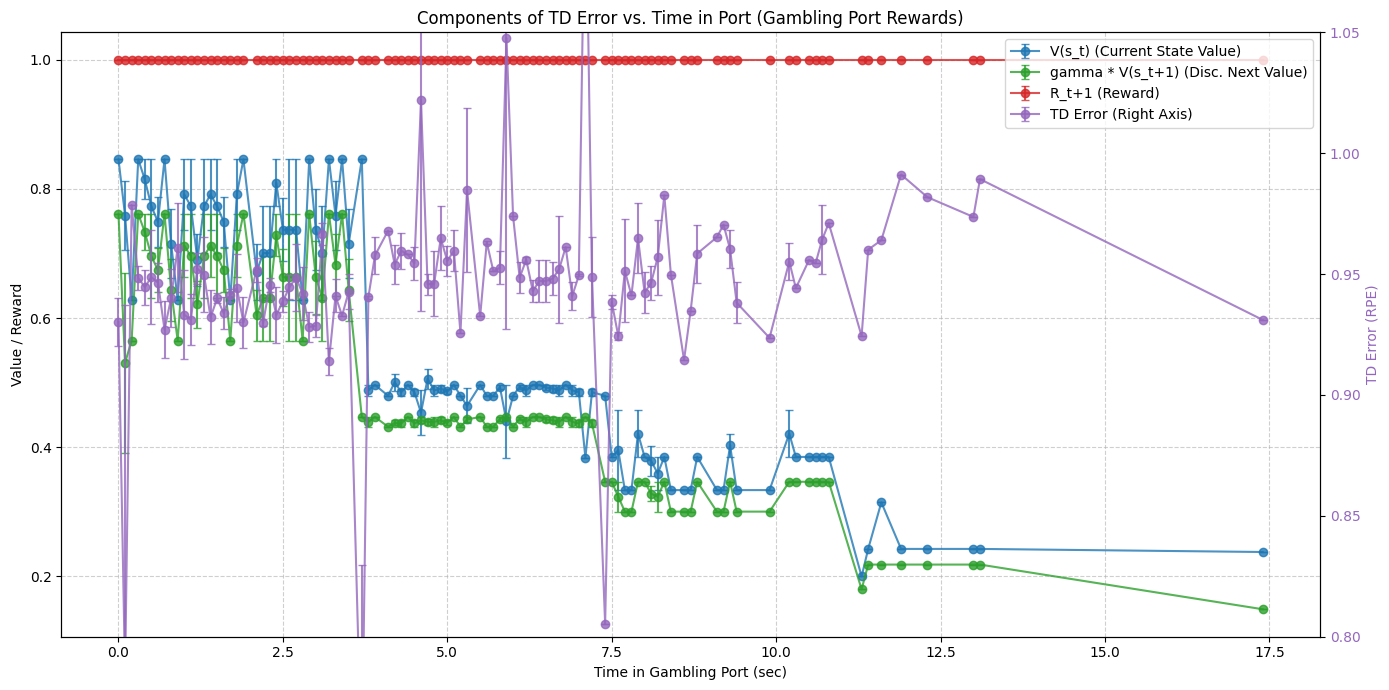

In [18]:
# --- Parameters ---
gambling_port_id = 1.0
gambling_enabled_flag = 0.0
gamma = analysis_agent.discount # Use the agent's discount factor

# --- Extract Components for Rewarded Gambling Steps ---
plot_data_components = []

print("Extracting TD error components for rewarded gambling steps...")
for i in range(len(target_transitions)):
    obs_t, _, reward_t_plus_1, next_obs_t_plus_1, terminal_flag = target_transitions[i]
    td_error = target_td_errors_np[i]

    # Check conditions: reward > 0 AND in gambling port AND gambling enabled
    if reward_t_plus_1 > 0 and obs_t[0] == gambling_port_id and obs_t[5] == gambling_enabled_flag:
        time_in_port = obs_t[1]

        # Calculate V(s_t) - value of the state where reward was triggered
        v_current = analysis_agent.get_value(obs_t)

        # Calculate gamma * V(s_t+1)
        v_next = analysis_agent.get_value(next_obs_t_plus_1) if not terminal_flag else 0.0
        discounted_v_next = gamma * v_next

        plot_data_components.append({
            'time_in_port': time_in_port,
            'reward': reward_t_plus_1,
            'v_current': v_current,
            'discounted_v_next': discounted_v_next,
            'td_error': td_error,
            'context': int(obs_t[3]) # Keep context if needed for later filtering
        })

print(f"Found {len(plot_data_components)} rewarded steps in enabled gambling port.")

# --- Prepare DataFrame and Calculate Averages ---
if not plot_data_components:
    print("No relevant data points found to plot.")
else:
    df_components = pd.DataFrame(plot_data_components)

    # Group by time_in_port and calculate mean and SEM for each component
    avg_components = df_components.groupby('time_in_port').agg(
        reward_mean=('reward', 'mean'),
        reward_sem=('reward', 'sem'),
        v_current_mean=('v_current', 'mean'),
        v_current_sem=('v_current', 'sem'),
        disc_v_next_mean=('discounted_v_next', 'mean'),
        disc_v_next_sem=('discounted_v_next', 'sem'),
        td_error_mean=('td_error', 'mean'),
        td_error_sem=('td_error', 'sem')
    ).reset_index()

    # Fill NaN SEM values (occur for groups of size 1) with 0 for plotting
    avg_components = avg_components.fillna(0)

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot components sharing the left axis
    color_v_curr = 'tab:blue'
    color_v_next = 'tab:green'
    color_reward = 'tab:red'
    ax1.set_xlabel('Time in Gambling Port (sec)')
    ax1.set_ylabel('Value / Reward', color='black')
    ax1.errorbar(avg_components['time_in_port'], avg_components['v_current_mean'],
                 yerr=avg_components['v_current_sem'], label='V(s_t) (Current State Value)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_v_curr)
    ax1.errorbar(avg_components['time_in_port'], avg_components['disc_v_next_mean'],
                 yerr=avg_components['disc_v_next_sem'], label='gamma * V(s_t+1) (Disc. Next Value)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_v_next)
    ax1.errorbar(avg_components['time_in_port'], avg_components['reward_mean'],
                 yerr=avg_components['reward_sem'], label='R_t+1 (Reward)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_reward)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Create a second y-axis for the TD error
    ax2 = ax1.twinx()
    color_td = 'tab:purple'
    ax2.set_ylabel('TD Error (RPE)', color=color_td)
    ax2.errorbar(avg_components['time_in_port'], avg_components['td_error_mean'],
                 yerr=avg_components['td_error_sem'], label='TD Error (Right Axis)',
                 fmt='-o', capsize=3, alpha=0.8, color=color_td)
    ax2.tick_params(axis='y', labelcolor=color_td)
    ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a zero line for TD error
    ax2.set_ylim([0.8, 1.05])

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Components of TD Error vs. Time in Port (Gambling Port Rewards)')
    fig.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()